In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

PREV_GAMES = 5
weight = np.array([.05, .1, .2, .3, .35])
#weight = [.15,.35,.5]
#weight = [.01,.04,.05,.1,.2,.3,.3]
dir_name = os.getcwd()
datasets = []
data_full = pd.DataFrame()
for suffix in ['16-17', '17-18', '18-19']:
    csv = dir_name + '/data/match_stats' +'_'+ suffix + '.csv' 
    dat = pd.read_csv(csv)
    datasets.append(dat)
    data_full = pd.concat((data_full, dat)).reset_index(drop=True)
data_full


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,E0,13/08/16,Burnley,Swansea,0,1,A,0,0,D,...,1.61,32,-0.25,2.13,2.06,1.86,1.81,2.79,3.16,2.89
1,E0,13/08/16,Crystal Palace,West Brom,0,1,A,0,0,D,...,1.52,33,-0.50,2.07,2.00,1.90,1.85,2.25,3.15,3.86
2,E0,13/08/16,Everton,Tottenham,1,1,D,1,0,H,...,1.77,32,0.25,1.91,1.85,2.09,2.00,3.64,3.54,2.16
3,E0,13/08/16,Hull,Leicester,2,1,H,1,0,H,...,1.67,31,0.25,2.35,2.26,2.03,1.67,4.68,3.50,1.92
4,E0,13/08/16,Man City,Sunderland,2,1,H,1,0,H,...,2.48,34,-1.50,1.81,1.73,2.20,2.14,1.25,6.50,14.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,E0,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,...,2.31,22,-1.50,1.98,1.91,2.01,1.95,1.32,5.89,9.48
1136,E0,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,...,2.95,21,-2.00,2.52,2.32,1.72,1.64,1.30,6.06,9.71
1137,E0,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,...,2.29,22,-1.50,2.27,2.16,1.80,1.73,1.37,5.36,8.49
1138,E0,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,...,2.07,19,-0.50,2.13,2.08,1.85,1.80,1.91,3.81,4.15


In [13]:
# get net scores
for data in datasets:
    data['goal_diff'] = data['FTHG'] - data['FTAG']
    data['shot_diff'] = data['HST'] - data['AST']
    data['corner_diff'] = data['HC'] - data['AC']

    print(data[data['FTR'] == 'D'].shape[0], data[data['FTR'] == 'A'].shape[0], data[data['FTR'] == 'H'].shape[0])

84 109 187
99 108 173
71 128 181


In [37]:
counter = {}
res = {}

def update_team_data(team, raw_dat, results, data_vec, is_away):
    '''
    Builds dictionary that maps a team to its weighted average score in three categories over Prev_Games.
    
    Parameters:
    team (str): team name
    raw_dat (dic): dictionary that maps a team its raw data over the past Prev_games
    results (dic): maps a team to its weighted average (over Prev_GAMES) score in three categories
    data_vec (np.array): the raw data. Columns 2-4 and 62-65 in the orginial dataframe.
    is_away (bool): Since the data is of the form Home-Away, we must reverse the sign when computing the
                    score of the away team.
    
    '''
    if is_away:
        sgn = -1
    else:
        sgn = 1
    if team not in raw_dat:
        raw_dat[team] = sgn * data_vec
    elif raw_dat[team].shape[0] < PREV_GAMES:
        raw_dat[team] = np.vstack((raw_dat[team], sgn * data_vec))
    else:
        results[team] = dict(zip(['goal', 'shot', 'corner'], np.average(raw_dat[team].astype('float'), axis=0, weights=weight)))
        raw_dat[team] = np.vstack((raw_dat[team][1:,], sgn * data_vec))
   
    return results
        


def get_avg_diff(row, dic, results):
    '''
    Creates a list containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    Parameters:
    row (series): A row of the form (home team name, away team name, goal diff, shot diff, corner diff)
    dic: Dictionary that maps a team its raw data over the past Prev_games
    results (dic): Maps a team to its weighted average (over Prev_GAMES) score in three categories
    
    returns:
    diff (lst): list of length 3 containing the difference between the home team and the away team in
    the three categories from the results dictionary
    
    
    '''
    update_team_data(row[0], dic, results, row[2:5], False)
    res = update_team_data(row[1], dic, results, row[2:5], True)
    #print(res.keys())
    if row[0] in res and row[1] in res:
        diff = []
        for key in results[row[0]].keys():
            diff.append(results[row[0]][key] - results[row[1]][key])
            
        return diff
    
    return [0,0,0]



#Create feature matrix
X_mat = pd.DataFrame()
y = pd.DataFrame()
for data in datasets:
    X_mat = pd.concat((X_mat, data.iloc[:,np.r_[2:4, 62:65]].apply(
        get_avg_diff, axis=1, dic=counter, results=res, result_type='expand').iloc[10 * PREV_GAMES:,].reset_index(drop=True))).reset_index(drop=True)
    label_encoder = preprocessing.LabelEncoder()
    y = pd.concat((y, pd.DataFrame(label_encoder.fit_transform(data.iloc[10 * PREV_GAMES:,6].reset_index(drop=True))))).reset_index(drop=True)
X_mat.columns = ['goals', 'shots', 'corners']
y.columns = ['Result']


In [38]:
#Split data into training, validation, and test sets

tr, val, tst = np.split(pd.concat((X_mat,y),axis=1).sample(frac=1, random_state=42),
                         [int(len(X_mat) * .6), int(len(X_mat) * .8)])
X_tr = tr.iloc[:,:3]
y_tr = tr.iloc[:,3]
X_val = val.iloc[:,:3]
y_val = val.iloc[:,3]
X_tst = tst.iloc[:,:3]
y_tst = tst.iloc[:,3]


In [39]:
def tune_hyperparams(mod, Xtr, ytr, Xval, yval, param_grid, fit_param_dic):
    '''
    Fits model for each element in the cartesian product of the lists of possible values of each parameter
    given by the param_grid. Then selects the best model based on the validation accuracy.
    
    Parameters:
    mod (obj): A multiclass classifier
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    param_grid (dic): maps each parameter to a list of values to be tested
    fit_param_dic (dic): used to implement early stopping for xgboost. Is an empty dictionary for all other classifiers
    
    Returns:
    validation_scores (dic): maps a given combination of parameters to the validation score for that model
    best_params_dic (dic): maps the parameter to its optimals value
    
    
    '''
    validation_scores = {}
    keys, vals = zip(*sorted(param_grid.items()))
    for it, params in enumerate(itertools.product(*vals)):
        #print(dict(zip(keys, params)))
        if it % 50 == 0:
            print(it, params)
        mod.set_params(**dict(zip(keys, params)))
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), ('clf', mod)])
        pipe.fit(Xtr, ytr, **fit_param_dic)
        validation_scores[params] = pipe.score(Xval, yval)
    best_params = max(validation_scores, key=validation_scores.get)
    best_params_dic = dict(zip(keys, best_params))
    
    return validation_scores, best_params_dic

0 (0.03, 1, 1, 3, 2, 300, 3, 'multi:softmax', 1)
{'eta': 0.03, 'gamma': 1, 'lambda': 1, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 1}
0 (1.0, 0.001, 'rbf')
{'C': 10.0, 'gamma': 0.1778279410038923, 'kernel': 'rbf'}
0 (0.001, 'multinomial', 'sag')
50 (0.0015863565335085897, 'multinomial', 'sag')
100 (0.002516527051405392, 'multinomial', 'sag')
150 (0.003992109129748053, 'multinomial', 'sag')
200 (0.006332908400455114, 'multinomial', 'sag')
250 (0.010046250617173407, 'multinomial', 'sag')
300 (0.015936935303817745, 'multinomial', 'sag')
350 (0.025281661443314993, 'multinomial', 'sag')
400 (0.04010572880855496, 'multinomial', 'sag')
450 (0.06362198492657485, 'multinomial', 'sag')
{'C': 0.030688378919176425, 'multi_class': 'multinomial', 'solver': 'sag'}
[00:26:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merr

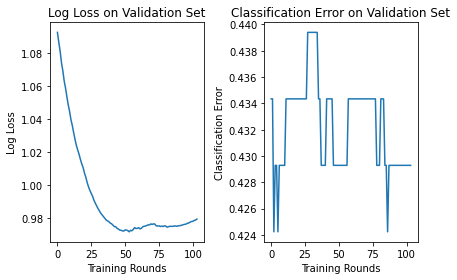

In [69]:
#Note parameters were tuned one, or two at time to cut down on computation time, so the grid does not reflect all values 
#tested
param_grids = {'xgb': 
               {'subsample': [1], 
                'gamma': [1],
                'lambda':[1], 
                'eta': [.03], 'n_estimators': [300],
                'min_child_weight': [2], 'max_depth': [3],
                'objective': ['multi:softmax'],
                'num_class': [3] 
               },
               'svc':
               {'C': np.logspace(0,3,4), 'gamma': np.geomspace(1e-3,1,5), 'kernel':['rbf']},
               'softmax': 
               {'C': np.geomspace(1e-3, 1e-1, 500), 'multi_class': ['multinomial'], 'solver': ['sag']} 
            }
optimal_mods = []
mods = [('xgb', XGBClassifier(use_label_encoder=False)), ('svc', SVC()), ('softmax', LogisticRegression())]
for name, mod in mods:
    fit_params = {}
    if name == 'xgb':
        fit_params = {'clf__early_stopping_rounds': 50, 'clf__eval_set': [(X_val.values, y_val.values)], 
                      'clf__eval_metric':['merror','mlogloss'], 'clf__verbose':False}
    val_scores, best_params = tune_hyperparams(mod, X_tr, y_tr, X_val, y_val, param_grids[name], fit_params)
    print(best_params)
    pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()), (name, mod.set_params(**best_params))])
    optimal_mods.append(pipe)
top_score = 0
for mod in optimal_mods:
    mod.fit(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))  #refit best models on training and validation sets
    test_score = mod.score(X_tst, y_tst)
    print(test_score, mod[1])
    if test_score >= top_score:
        best_mod = mod
        top_score = test_score


#Plot validation loss to see if early stopping is needed
fig, ax = plt.subplots(1,2)
eval_res = optimal_mods[0]['xgb'].evals_result()
ax[0].plot(range(0, len(eval_res['validation_0']['mlogloss'])), eval_res['validation_0']['mlogloss'])
ax[1].plot(range(0, len(eval_res['validation_0']['merror'])), eval_res['validation_0']['merror'])
ax[0].set(xlabel = 'Training Rounds', ylabel = 'Log Loss')
ax[1].set(xlabel='Training Rounds', ylabel='Classification Error')
ax[0].set_title('Log Loss on Validation Set')
ax[1].set_title('Classification Error on Validation Set')
plt.tight_layout()
plt.show()   


In [64]:
def simple_strat(row):
    '''
    Defines a simple betting strategy where 1 dollar is bet on the outcome with the highest probability
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won
    
    
    
    '''
    if row[0] != row[1]:
        return -1 
    if row[0] == 'H':
        return row[4]
    elif row[0] == 'A':
        return row[6]
    else:
        return row[5]

MIN_PROB = .45
FACTOR = 5
def conservative_strat(row):
    '''
    Defines a betting strategy where a bet is placed only if the probability associated with the most likely class is
    .5 or greater. If a bet is made, the wager is proportional to the product of the probability and some constant.
    
    Parameters: row containing prediction, true result and betting information
    
    Returns: 1 if bet is lost, and the payout given by the odds if won    
    '''
    if row[2] >= MIN_PROB:
        wager = round(row[2] * FACTOR, 2)
        if row[0] != row[1]:
            return -wager
        elif row[0] == 'H':
            return row[4] * wager
        elif row[0] == 'A':
            return row[6] * wager
        else:
            return row[5] * wager
    else:
        return 0

In [65]:
ypred = best_mod.predict(X_tst)
ys = np.vstack((ypred, y_tst))
ys = np.where(ys==2,'H', np.where(ys==0, 'A', 'D')) #convert back to original labels
probs = np.max(best_mod.predict_proba(X_tst), axis=1)
pred_target_prob = pd.DataFrame(np.vstack((ys, probs)).T, columns=['ypred', 'ytest', 'predicted_prob'])
pred_target_prob = pred_target_prob.astype({'predicted_prob': float})
odds = data_full.iloc[10 * PREV_GAMES:,23:26].reset_index(drop=True).iloc[y_tst.index].reset_index()
winnings_dat = pd.concat((pred_target_prob, odds), axis=1)
#print(winnings_dat)

for strat in [simple_strat, conservative_strat]:
    winnings_dat['winnings'] = winnings_dat.apply(strat, axis=1)
    print(sum(winnings_dat['winnings']))
    print(winnings_dat)
    print(winnings_dat.iloc[winnings_dat['winnings'].idxmax(),:])


245.03999999999996
    ypred ytest  predicted_prob  index  B365H  B365D  B365A  winnings
0       H     A        0.460926    947   1.22   7.00  15.00     -1.00
1       H     H        0.443020    577   1.75   3.50   6.00      1.75
2       H     H        0.483217     85   2.20   3.30   3.75      2.20
3       H     D        0.456469    242   2.00   3.40   4.33     -1.00
4       H     H        0.685205    698   1.18   8.50  17.00      1.18
..    ...   ...             ...    ...    ...    ...    ...       ...
193     A     A        0.421431    106  10.00   5.75   1.33      1.33
194     H     H        0.505470    270   2.55   3.20   2.80      2.55
195     A     A        0.443532    860   1.28   6.00  12.00     12.00
196     H     H        0.496116    435   5.25   4.33   1.66      5.25
197     H     A        0.362292    102   5.25   4.00   1.70     -1.00

[198 rows x 8 columns]
ypred                    A
ytest                    A
predicted_prob    0.374486
index                  683
B365H    